In [1]:
import numpy as np 
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

In [2]:

train=pd.read_csv('../balanced_cleaned_trian_dataset.csv',index_col=0)
test_set=pd.read_csv('../testset.csv',index_col=0)


In [3]:
train_copy=train.drop('id',axis=1)
X = train_copy.drop('smoking', axis=1)
y = train_copy['smoking']

test_set=test_set.drop('id',axis=1)
X_test= test_set.drop('smoking', axis=1)
y_test = test_set['smoking']


In [4]:
import optuna
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np


In [5]:


skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def objective(trial):
    
    n_estimators = trial.suggest_int('n_estimators', 100, 500, step=20)
    max_depth = trial.suggest_int('max_depth', 5, 25)
    max_features = trial.suggest_int('max_features', 3, 15)

    scores = []
    F1=[]

    for train_idx, val_idx in skf.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        
        # scaler = MinMaxScaler()
        # X_train_scaled = scaler.fit_transform(X_train)
        # X_val_scaled = scaler.transform(X_val)

        
        rf = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            max_features=max_features,
            random_state=42,
            n_jobs=-1  
        )
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_val)
        
        acc = accuracy_score(y_val, y_pred)
        F1c=f1_score(y_val, y_pred, average='macro') 
        F1.append(F1c)
        

        y_pred_train = rf.predict(X_train)
        acc_train = accuracy_score(y_train, y_pred_train)
        f1_train = f1_score(y_train, y_pred_train, average='macro')
        

        overfit_penalty = abs(acc_train - acc)
        score = 0.5 * acc - 0.5 * overfit_penalty
        scores.append(score)
    return np.mean(scores)


sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='maximize',sampler=sampler)
study.optimize(objective, n_trials=20)  


print("best_params:", study.best_params)
print(f"Best_value: {study.best_value:.4f}")

[I 2025-08-14 10:48:24,620] A new study created in memory with name: no-name-55fb72c5-8f92-40fc-becb-64f1fe61116f
[I 2025-08-14 10:48:33,768] Trial 0 finished with value: 0.27496875 and parameters: {'n_estimators': 240, 'max_depth': 24, 'max_features': 12}. Best is trial 0 with value: 0.27496875.
[I 2025-08-14 10:48:37,792] Trial 1 finished with value: 0.37055 and parameters: {'n_estimators': 340, 'max_depth': 8, 'max_features': 5}. Best is trial 1 with value: 0.37055.
[I 2025-08-14 10:48:42,285] Trial 2 finished with value: 0.2727875 and parameters: {'n_estimators': 120, 'max_depth': 23, 'max_features': 10}. Best is trial 1 with value: 0.37055.
[I 2025-08-14 10:48:47,991] Trial 3 finished with value: 0.37883125 and parameters: {'n_estimators': 380, 'max_depth': 5, 'max_features': 15}. Best is trial 3 with value: 0.37883125.
[I 2025-08-14 10:48:53,061] Trial 4 finished with value: 0.36291874999999996 and parameters: {'n_estimators': 440, 'max_depth': 9, 'max_features': 5}. Best is tria

best_params: {'n_estimators': 460, 'max_depth': 5, 'max_features': 13}
Best_value: 0.3791


In [6]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = []
for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # scaler = MinMaxScaler()
    # X_train_scaled = scaler.fit_transform(X_train)
    # X_val_scaled = scaler.transform(X_val)

    rf = RandomForestClassifier(
            n_estimators=460,
            max_depth=5,
            max_features=13,
            random_state=42
        )
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)

    acc = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred, average='macro')
    recall = recall_score(y_val, y_pred, average='macro')
    f1 = f1_score(y_val, y_pred, average='macro')

    print(f"Fold {fold + 1}:")
    print(f"  Accuracy:  {acc:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1 Score:  {f1:.4f}")
    print("-" * 30)

    train_pred = rf.predict(X_train)
    train_acc = accuracy_score(y_train, train_pred)
    print(f"Train Accuracy: {train_acc:.4f}, Val Accuracy: {acc:.4f}")
    print(f"Fold {fold + 1} Classification Report:")
    print(classification_report(y_val, y_pred, digits=2))
    print("-" * 40)
    
    scores.append(acc)

    avg_acc = np.mean(scores)

Fold 1:
  Accuracy:  0.7688
  Precision: 0.7883
  Recall:    0.7688
  F1 Score:  0.7648
------------------------------
Train Accuracy: 0.7792, Val Accuracy: 0.7688
Fold 1 Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.64      0.73      2000
           1       0.71      0.90      0.80      2000

    accuracy                           0.77      4000
   macro avg       0.79      0.77      0.76      4000
weighted avg       0.79      0.77      0.76      4000

----------------------------------------
Fold 2:
  Accuracy:  0.7745
  Precision: 0.7881
  Recall:    0.7745
  F1 Score:  0.7718
------------------------------
Train Accuracy: 0.7746, Val Accuracy: 0.7745
Fold 2 Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.67      0.75      2000
           1       0.73      0.88      0.80      2000

    accuracy                           0.77      4000
   macro avg       0.79   

In [7]:
rf_final = RandomForestClassifier(
    n_estimators=460,
            max_depth=5,
            max_features=13,
            random_state=42
)
rf_final.fit(X, y)  

y_test_pred = rf_final.predict(X_test)

acc_test = accuracy_score(y_test, y_test_pred)
precision_test = precision_score(y_test, y_test_pred, average='macro')
recall_test = recall_score(y_test, y_test_pred, average='macro')
f1_test = f1_score(y_test, y_test_pred, average='macro')

train_pred = rf_final.predict(X)  
train_acc = accuracy_score(y, train_pred)
print(f"Train Accuracy: {train_acc:.4f}, test Accuracy: {acc_test:.4f}")

print(f"Test set Accuracy:  {acc_test:.4f}")
print(f"Test set Precision: {precision_test:.4f}")
print(f" Test set Recall:    {recall_test:.4f}")
print(f" Test set F1 Score:  {f1_test:.4f}")
print("\n Test set classification report:")
print(classification_report(y_test, y_test_pred, digits=4))

Train Accuracy: 0.7757, test Accuracy: 0.7710
Test set Accuracy:  0.7710
Test set Precision: 0.7861
 Test set Recall:    0.7710
 Test set F1 Score:  0.7679

 Test set classification report:
              precision    recall  f1-score   support

           0     0.8519    0.6560    0.7412      1000
           1     0.7203    0.8860    0.7946      1000

    accuracy                         0.7710      2000
   macro avg     0.7861    0.7710    0.7679      2000
weighted avg     0.7861    0.7710    0.7679      2000



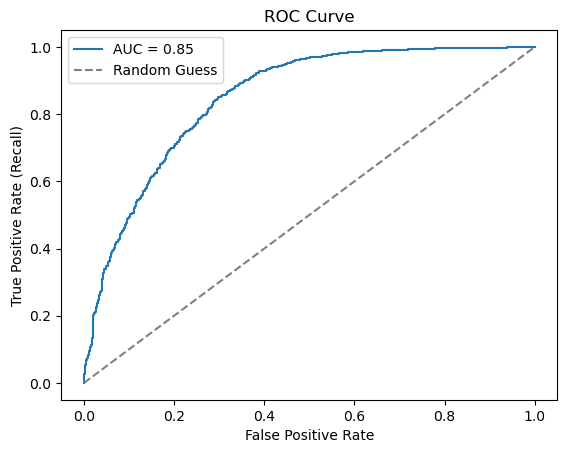

In [8]:

y_test_proba = rf_final.predict_proba(X_test)[:, 1]  


fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
auc = roc_auc_score(y_test, y_test_proba)


plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="grey", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [ ]:
#from sklearn.model_selection import StratifiedKFold
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score
# import numpy as np
# from itertools import product
# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)




# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [5, 10],
#     'max_features': [3,4, 6,8,]
# }


# param_combinations = list(product(
#     param_grid['n_estimators'],
#     param_grid['max_depth'],
#     param_grid['max_features']
# ))

# best_score = 0
# best_params = None


# results = []
# for n_est, max_d, max_feat in param_combinations:
#     scores = []
#     for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
#         X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
#         y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

#         scaler = MinMaxScaler()
#         X_train_scaled = scaler.fit_transform(X_train)
#         X_val_scaled = scaler.transform(X_val)

#         rf = RandomForestClassifier(
#             n_estimators=n_est,
#             max_depth=max_d,
#             max_features=max_feat,
#             random_state=42
#         )
#         rf.fit(X_train_scaled, y_train)
#         y_pred = rf.predict(X_val_scaled)
#         acc = accuracy_score(y_val, y_pred)
#         scores.append(acc)

#     avg_acc = np.mean(scores)
#     print(f"Params: n_estimators={n_est}, max_depth={max_d}, max_features={max_feat} --> Acc: {avg_acc:.4f}")

#     results.append([n_est, max_d, max_feat, avg_acc])

#     if avg_acc > best_score:
#         best_score = avg_acc
#         best_params = (n_est, max_d, max_feat)

# print(f"最佳参数组合: n_estimators={best_params[0]}, max_depth={best_params[1]}, max_features={best_params[2]}")
# print(f"对应平均准确率: {best_score:.4f}")


# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt


# df_results = pd.DataFrame(results, columns=["n_estimators", "max_depth", "max_features", "accuracy"])

# # n_estimators = 100 和 200
# for n in df_results['n_estimators'].unique():
#     pivot = df_results[df_results["n_estimators"] == n].pivot(
#         index="max_depth", columns="max_features", values="accuracy"
#     )

#     plt.figure(figsize=(6, 4))
#     sns.heatmap(pivot, annot=True, fmt=".4f", cmap="YlGnBu")
#     plt.title(f"Accuracy Heatmap (n_estimators = {n})")
#     plt.xlabel("max_features")
#     plt.ylabel("max_depth")
#     plt.tight_layout()
#     plt.show()